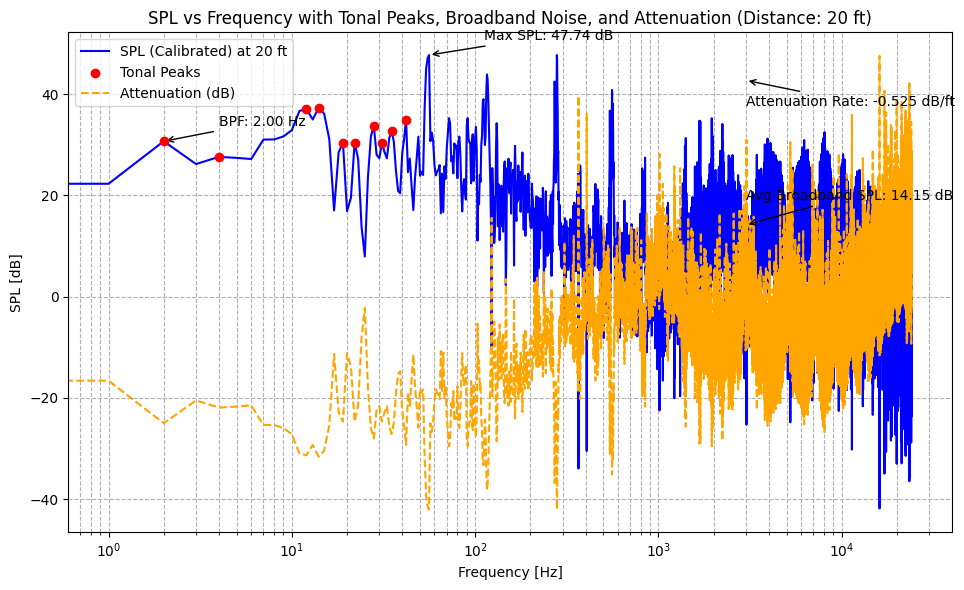

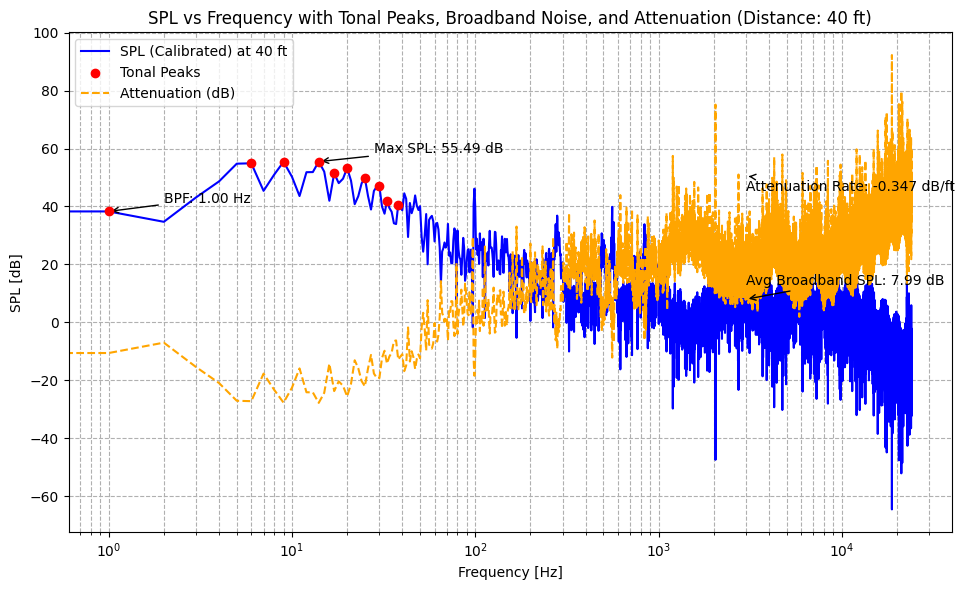

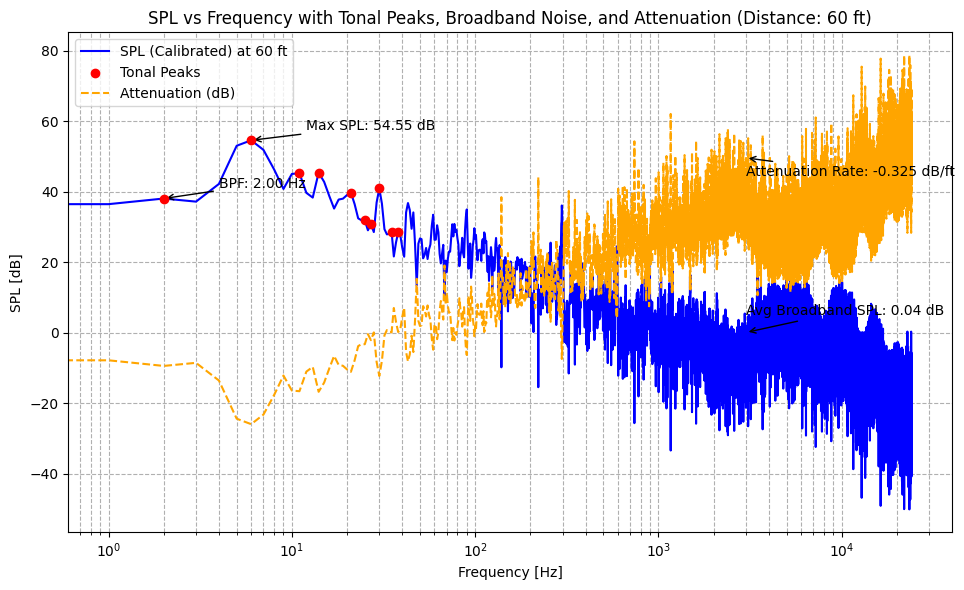

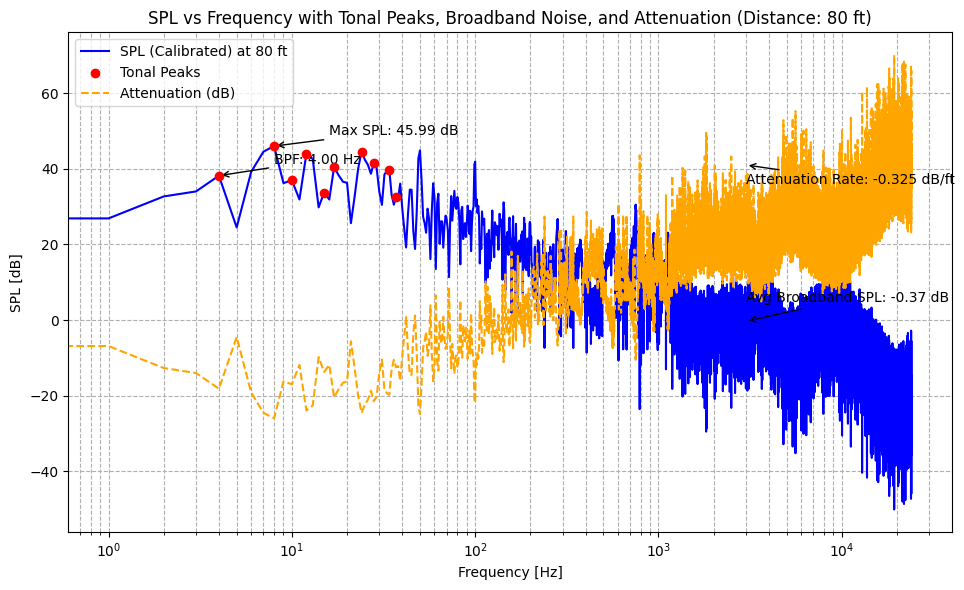

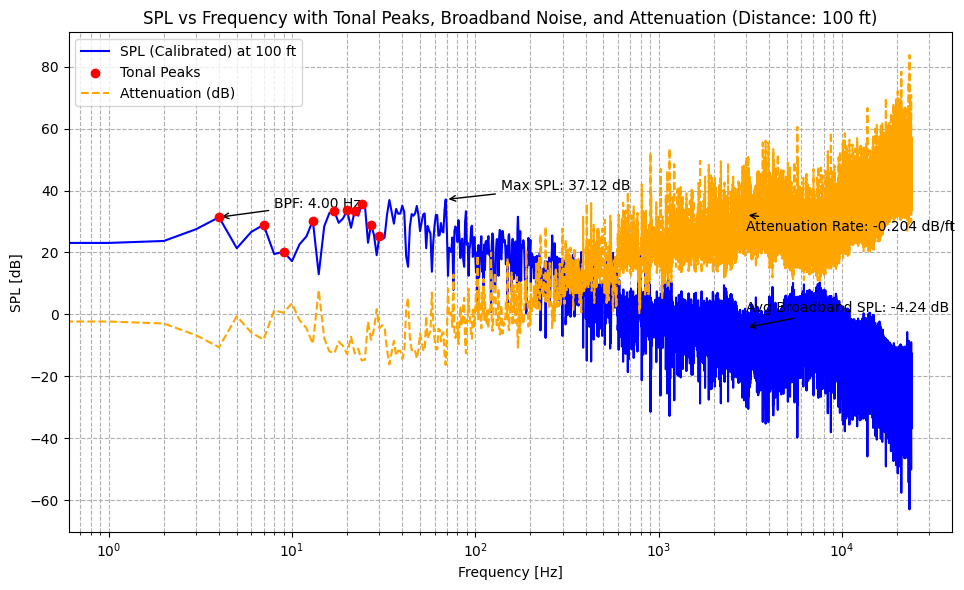

Comparison of Broadband SPL, Max SPL, Attenuation Rate, and BPF:
Distance: 20 ft - Avg Broadband SPL: 14.15 dB, Max SPL: 47.74 dB, Attenuation Rate: -0.525 dB/ft, BPF: 2.00 Hz
Distance: 40 ft - Avg Broadband SPL: 7.99 dB, Max SPL: 55.49 dB, Attenuation Rate: -0.347 dB/ft, BPF: 1.00 Hz
Distance: 60 ft - Avg Broadband SPL: 0.04 dB, Max SPL: 54.55 dB, Attenuation Rate: -0.325 dB/ft, BPF: 2.00 Hz
Distance: 80 ft - Avg Broadband SPL: -0.37 dB, Max SPL: 45.99 dB, Attenuation Rate: -0.325 dB/ft, BPF: 4.00 Hz
Distance: 100 ft - Avg Broadband SPL: -4.24 dB, Max SPL: 37.12 dB, Attenuation Rate: -0.204 dB/ft, BPF: 4.00 Hz


In [ ]:
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt

def read_calibration_file(calibration_path):
    """
    Reads the UMIK-1 calibration file (frequency in Hz and dB correction).
    Returns interpolating function for calibration.
    """
    # Load calibration file data
    data = np.loadtxt(calibration_path, skiprows=1)  # Skip first row with Sens Factor
    freq, correction = data[:, 0], data[:, 1]
    # Interpolation for calibration curve
    calibration_interp = np.interp
    return lambda f: calibration_interp(f, freq, correction)

def compute_spl_db(fft_magnitude, ref=20e-6):
    """
    Convert magnitude to SPL in dB. ref is 20 µPa.
    """
    return 20 * np.log10(fft_magnitude / ref + 1e-20)  # Avoid log(0)

def find_tonal_peaks(freqs, spl, threshold=5, num_peaks=10):
    """
    Finds the first `num_peaks` tonal peaks in the SPL spectrum based on a simple threshold
    compared to the surrounding frequency range.
    """
    peaks, _ = signal.find_peaks(spl, height=threshold)
    return freqs[peaks][:num_peaks], spl[peaks][:num_peaks]  # Return only the first `num_peaks` peaks

def find_broadband_noise_range(freqs, spl, min_freq=1000, max_freq=10000):
    """
    Identifies the broadband noise region by isolating a frequency range
    from min_freq to max_freq.
    """
    freq_mask = (freqs >= min_freq) & (freqs <= max_freq)
    return freqs[freq_mask], spl[freq_mask]

def process_audio_file(wav_path, calibration_path):
    # Load audio file
    data, samplerate = sf.read(wav_path)
    
    # If stereo, convert to mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Apply a Hann window
    window = np.hanning(len(data))
    data_windowed = data * window

    # FFT
    fft_result = np.fft.rfft(data_windowed)
    freqs = np.fft.rfftfreq(len(data), 1/samplerate)
    fft_magnitude = np.abs(fft_result) / len(data_windowed)

    # Load and interpolate calibration correction
    calib_func = read_calibration_file(calibration_path)
    calib_correction_db = calib_func(freqs)

    # Convert to SPL in dB
    spl = compute_spl_db(fft_magnitude)
    spl_calibrated = spl + calib_correction_db  # Apply calibration

    return freqs, spl_calibrated

def label_and_plot_spl(freqs, spl_calibrated, distance, reference_spl):
    # Find tonal peaks (first 10 peaks)
    peaks_freq, peaks_spl = find_tonal_peaks(freqs, spl_calibrated, threshold=5, num_peaks=10)

    # Find broadband noise region
    broadband_freq, broadband_spl = find_broadband_noise_range(freqs, spl_calibrated, min_freq=1000, max_freq=10000)

    # Calculate the average SPL in the broadband noise range
    avg_broadband_spl = np.mean(broadband_spl)

    # Calculate the SPL attenuation (difference from reference SPL)
    attenuation = reference_spl - spl_calibrated

    # Calculate the attenuation rate (dB per unit distance)
    distance_ref = 20  # Reference distance (e.g., 20 ft)
    max_distance = 100  # Max distance to consider
    attenuation_rate = (reference_spl - max(spl_calibrated)) / (max_distance - distance_ref)

    # Plot the SPL vs Frequency
    plt.figure(figsize=(10, 6))
    plt.semilogx(freqs, spl_calibrated, label=f'SPL (Calibrated) at {distance} ft', color='blue')

    # Plot only the first 10 tonal peaks
    plt.scatter(peaks_freq, peaks_spl, color='red', label='Tonal Peaks', zorder=5)

    # Calculate the max SPL
    max_spl = np.max(spl_calibrated)

    # Annotate the Max SPL in a better position
    plt.annotate(f'Max SPL: {max_spl:.2f} dB', xy=(freqs[np.argmax(spl_calibrated)], max_spl),
                 xytext=(freqs[np.argmax(spl_calibrated)] * 2, max_spl + 3),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Label the broadband noise effect
    plt.annotate(f'Avg Broadband SPL: {avg_broadband_spl:.2f} dB', xy=(3000, avg_broadband_spl),
                 xytext=(3000, avg_broadband_spl + 5),
                 arrowprops=dict(facecolor='green', arrowstyle='->'))

    # Plot the attenuation as a line
    plt.plot(freqs, attenuation, label='Attenuation (dB)', color='orange', linestyle='--')

    # Annotate the attenuation rate
    plt.annotate(f'Attenuation Rate: {attenuation_rate:.3f} dB/ft', xy=(3000, max_spl - 5),
                 xytext=(3000, max_spl - 10),
                 arrowprops=dict(facecolor='orange', arrowstyle='->'))

    # Find the first tonal peak and annotate its frequency (BPF)
    first_tonal_peak_freq = peaks_freq[0]
    plt.annotate(f'BPF: {first_tonal_peak_freq:.2f} Hz', xy=(first_tonal_peak_freq, peaks_spl[0]),
                 xytext=(first_tonal_peak_freq * 2, peaks_spl[0] + 3),
                 arrowprops=dict(facecolor='red', arrowstyle='->'))

    # Labels and Title
    plt.title(f'SPL vs Frequency with Tonal Peaks, Broadband Noise, and Attenuation (Distance: {distance} ft)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('SPL [dB]')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return the Avg Broadband SPL, Max SPL, and attenuation for comparison
    return avg_broadband_spl, max_spl, attenuation_rate, first_tonal_peak_freq

# === Usage ===
calibration_file = r"D:\FYP\Final Project\calibration_file.txt"  # Path to the calibration file
distances = [20, 40, 60, 80, 100]  # Different distances from the mic in feet

# Paths to the audio files for each distance
wav_files = [
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d20_h10_seg2.wav",  # Path to audio file for 20 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d40_h10_seg10.wav",  # Path to audio file for 40 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d60_h10_seg1.wav",  # Path to audio file for 60 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d80_h10_seg1.wav",  # Path to audio file for 80 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d100_h101_seg9.wav"  # Path to audio file for 100 ft distance
]

# Collect Avg Broadband SPL, Max SPL, attenuation, and first tonal peak frequency for comparison
comparison_data = []

# Process each audio file and plot a separate graph for each distance
for wav_file, distance in zip(wav_files, distances):
    freqs, spl_calibrated = process_audio_file(wav_file, calibration_file)
    reference_spl = spl_calibrated[0]  # Assuming reference SPL at the lowest frequency
    avg_broadband_spl, max_spl, attenuation_rate, first_tonal_peak_freq = label_and_plot_spl(freqs, spl_calibrated, distance, reference_spl)
    comparison_data.append((distance, avg_broadband_spl, max_spl, attenuation_rate, first_tonal_peak_freq))

# Print the comparison data for each plot including the first tonal peak frequency
print("Comparison of Broadband SPL, Max SPL, Attenuation Rate, and BPF:")
for distance, avg_broadband_spl, max_spl, attenuation_rate, first_tonal_peak_freq in comparison_data:
    print(f"Distance: {distance} ft - Avg Broadband SPL: {avg_broadband_spl:.2f} dB, Max SPL: {max_spl:.2f} dB, Attenuation Rate: {attenuation_rate:.3f} dB/ft, BPF: {first_tonal_peak_freq:.2f} Hz")


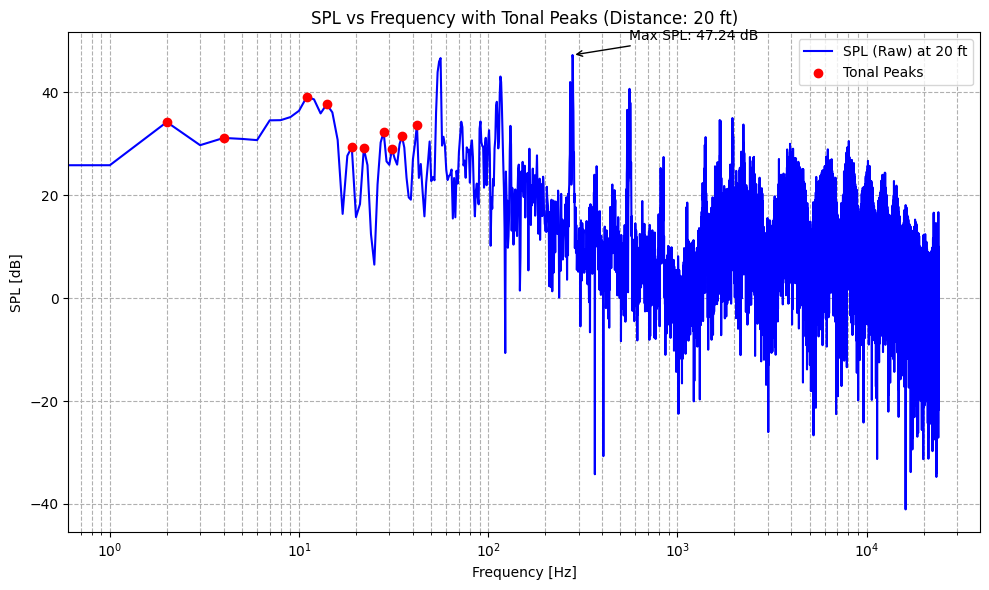

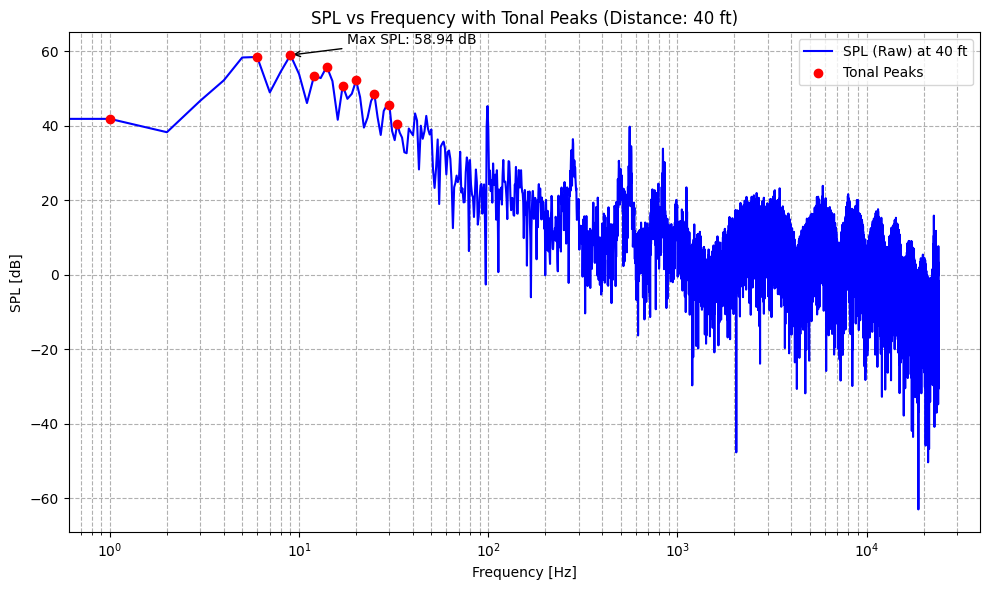

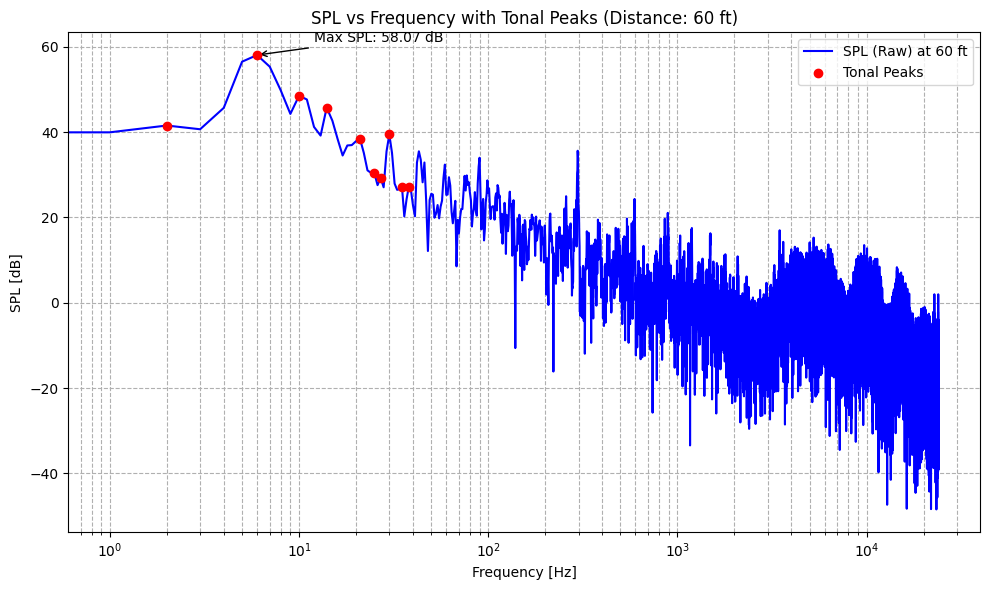

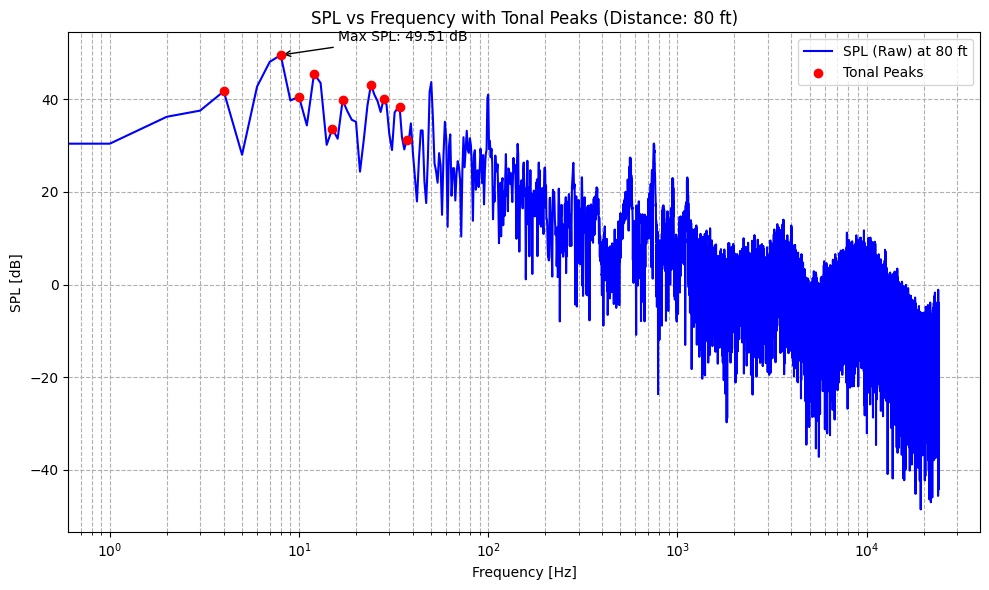

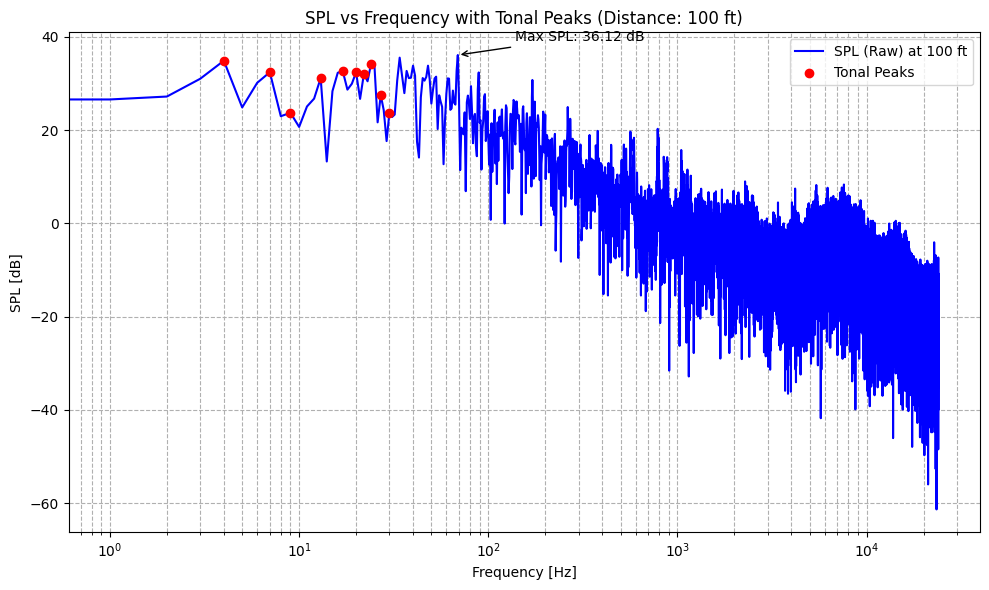

In [2]:
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt

def compute_spl_db(fft_magnitude, ref=20e-6):
    """
    Convert magnitude to SPL in dB. ref is 20 µPa.
    """
    return 20 * np.log10(fft_magnitude / ref + 1e-20)  # Avoid log(0)

def find_tonal_peaks(freqs, spl, threshold=5, num_peaks=10):
    """
    Finds the first `num_peaks` tonal peaks in the SPL spectrum based on a simple threshold
    compared to the surrounding frequency range.
    """
    peaks, _ = signal.find_peaks(spl, height=threshold)
    return freqs[peaks][:num_peaks], spl[peaks][:num_peaks]  # Return only the first `num_peaks` peaks

def process_audio_file(wav_path):
    # Load audio file
    data, samplerate = sf.read(wav_path)
    
    # If stereo, convert to mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Apply a Hann window
    window = np.hanning(len(data))
    data_windowed = data * window

    # FFT
    fft_result = np.fft.rfft(data_windowed)
    freqs = np.fft.rfftfreq(len(data), 1/samplerate)
    fft_magnitude = np.abs(fft_result) / len(data_windowed)

    # Convert to SPL in dB
    spl = compute_spl_db(fft_magnitude)
    
    return freqs, spl

def label_and_plot_spl(freqs, spl_calibrated, distance):
    # Find tonal peaks (first 10 peaks)
    peaks_freq, peaks_spl = find_tonal_peaks(freqs, spl_calibrated, threshold=5, num_peaks=10)

    # Plot the SPL vs Frequency
    plt.figure(figsize=(10, 6))
    plt.semilogx(freqs, spl_calibrated, label=f'SPL (Raw) at {distance} ft', color='blue')

    # Plot only the first 10 tonal peaks
    plt.scatter(peaks_freq, peaks_spl, color='red', label='Tonal Peaks', zorder=5)

    # Calculate the max SPL
    max_spl = np.max(spl_calibrated)

    # Annotate the Max SPL in a better position
    plt.annotate(f'Max SPL: {max_spl:.2f} dB', xy=(freqs[np.argmax(spl_calibrated)], max_spl),
                 xytext=(freqs[np.argmax(spl_calibrated)] * 2, max_spl + 3),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Labels and Title
    plt.title(f'SPL vs Frequency with Tonal Peaks (Distance: {distance} ft)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('SPL [dB]')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Usage ===
distances = [20, 40, 60, 80, 100]  # Different distances from the mic in feet

# Paths to the audio files for each distance
wav_files = [
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d20_h10_seg2.wav",  # Path to audio file for 20 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d40_h10_seg10.wav",  # Path to audio file for 40 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d60_h10_seg1.wav",  # Path to audio file for 60 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d80_h10_seg1.wav",  # Path to audio file for 80 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d100_h101_seg9.wav"  # Path to audio file for 100 ft distance
]


# Process each audio file and plot a separate graph for each distance
for wav_file, distance in zip(wav_files, distances):
    freqs, spl_calibrated = process_audio_file(wav_file)
    label_and_plot_spl(freqs, spl_calibrated, distance)
